# Digit Recognizer

My first, highly experimentative attempt at creating a digit recognizer using a neural network with regularization.

## Base Neural Network Class

The NeuralNetwork class is very simple. It initializes and holds the neural network, is capable of evaluating the network at a given point, and executing back propagation on a given set of data. This gives the client class quite a bit of freedom.

In [24]:
import numpy as np


class NeuralNetwork:
    def __init__(self, network_architecture, regularization_constant=0.0, learning_rate=0.1):
        self.regularization_constant = regularization_constant
        self.learning_rate = learning_rate
        self.num_layers = len(network_architecture)
        self.network_architecture = network_architecture
        # Here, weights[layer][i] gives the list of weights fed into the ith node of the given layer.
        self.weights = self._create_weight_array()
        # Here biases[layer][i] is the bias for the ith node of the given layer.
        self.biases = self._create_node_array()

    def _create_weight_array(self, randomize=True):
        arr = [None]
        for layer in range(1, self.num_layers):
            # We use normalized Xavier initialization.
            if randomize:
                randomizer = np.vectorize(lambda x: (np.random.random() - 0.5) * 2 * np.sqrt(6)
                    / np.sqrt(self.network_architecture[layer - 1] + self.network_architecture[layer]))
                arr.append(randomizer(
                    np.empty((self.network_architecture[layer], self.network_architecture[layer - 1]))
                ))
            else:
                arr.append(np.zeros((self.network_architecture[layer], self.network_architecture[layer - 1])))
        return arr

    def _create_node_array(self, randomize=True):
        arr = [None]
        for layer in range(1, self.num_layers):
            # We use normalized Xavier initialization.
            if randomize:
                randomizer = np.vectorize(lambda x: ((np.random.random() - 0.5) * 2 * np.sqrt(6)
                    / np.sqrt(self.network_architecture[layer - 1] + self.network_architecture[layer])))
                arr.append(randomizer(
                    np.empty((self.network_architecture[layer]))
                ))
            else:
                arr.append(np.zeros((self.network_architecture[layer])))
        return arr

    def compute_output_layers(self, input_layers):
        curr_layers = np.transpose(input_layers)
        for layer in range(1, self.num_layers):
            curr_layers = np.tanh(self.weights[layer] @ curr_layers
                + self.biases[layer].reshape(self.network_architecture[layer], 1))
        return np.transpose(curr_layers)

    def sgd(self, input_pts, output_pts, batch_size=1, num_epochs=1, log=True):
        num_pts = len(input_pts)
        num_batches = int(np.ceil(num_pts / batch_size))
        for epoch in range(num_epochs):
            if log:
                print("Epoch {} / {}".format(epoch + 1, num_epochs))
            order = np.arange(num_pts)
            np.random.shuffle(order)
            for batch in range(num_batches):
                self._back_prop(input_pts[batch * batch_size:(batch + 1) * batch_size],
                                output_pts[batch * batch_size:(batch + 1) * batch_size])
    
    def _back_prop(self, input_pts, output_pts):
        num_datapts = len(input_pts)
        weight_gradient = self._create_weight_array(randomize=False)
        bias_gradient = self._create_node_array(randomize=False)
        for input_layer, output_layer in zip(input_pts, output_pts):
            self._add_gradient(input_layer, output_layer, weight_gradient, bias_gradient)
        for curr_weight_vector, delta_weight in zip(self.weights, weight_gradient):
            if curr_weight_vector is not None:
                curr_weight_vector *= 1 - 2 * self.learning_rate * self.regularization_constant / num_datapts
                curr_weight_vector -= self.learning_rate * delta_weight / num_datapts
        for curr_bias_vector, delta_bias in zip(self.biases, bias_gradient):
            if curr_bias_vector is not None:
                curr_bias_vector *= 1 - 2 * self.learning_rate * self.regularization_constant / num_datapts
                curr_bias_vector -= self.learning_rate * delta_bias / num_datapts

    def _add_gradient(self, input_layer, output_layer, weight_gradient, bias_gradient):
        neuron_values = self._get_all_layers(input_layer)
        node_value_derivative = self._create_node_array(randomize=False)
        node_inner_value_derivative = self._create_node_array(randomize=False)
        for layer in range(self.num_layers - 1, 0, -1):
            curr_neuron_values = neuron_values[layer]
            if layer == self.num_layers - 1:
                # This is the output layer.
                output_layer_size = self.network_architecture[-1]
                node_value_derivative[layer] = 2 / output_layer_size * (curr_neuron_values - output_layer)
            else:
                node_value_derivative[layer] = (np.transpose(self.weights[layer + 1])
                                                @ node_inner_value_derivative[layer + 1])
            node_inner_value_derivative[layer] = ((1 - curr_neuron_values * curr_neuron_values)
                                                  * node_value_derivative[layer])
            curr_layer_size = self.network_architecture[layer]
            prev_layer_size = self.network_architecture[layer - 1]
            curr_inner_deriv = node_inner_value_derivative[layer].reshape((curr_layer_size, 1))
            prev_vals = neuron_values[layer - 1].reshape((1, prev_layer_size))
            weight_gradient[layer] += curr_inner_deriv @ prev_vals
            bias_gradient[layer] += node_inner_value_derivative[layer]

    def _get_all_layers(self, input_layer):
        layers = [input_layer]
        curr_layer = input_layer
        for layer in range(1, self.num_layers):
            curr_layer = np.tanh(self.weights[layer] @ curr_layer + self.biases[layer])
            layers.append(curr_layer)
        return layers


## Validation

In order to find the optimal parameters, we implement validation with a fifth of the training data. I was initially going to use 10-fold cross validation, but it proved to be too slow.

In [25]:
# Returns a tuple of arrays.
# First element is the array of validation errors after each epoch.
# Second element is the array of validation accuracies after each epoch.


def calc_errors(input_pts, output_pts, network_architecture,
                regularization_constant=0.0, learning_rate=0.1,
                num_epochs=30, batch_size=1, log=True):
    num_pts = len(input_pts)
    num_train_pts = num_pts * 4 // 5
    num_validation_pts = num_pts - num_train_pts
    training_inputs = input_pts[:num_train_pts]
    validation_inputs = input_pts[num_train_pts:]
    training_outputs = output_pts[:num_train_pts]
    validation_outputs = output_pts[num_train_pts:]
    network = NeuralNetwork(
        network_architecture,
        regularization_constant=regularization_constant,
        learning_rate=learning_rate
    )
    errors = np.empty(num_epochs)
    accuracies = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        if log:
            print("Epoch {} / {}:".format(epoch + 1, num_epochs))
        network.sgd(training_inputs, training_outputs,
                    batch_size=batch_size, log=False)
        validation_results = network.compute_output_layers(validation_inputs)
        errors[epoch] = np.average(np.square(validation_results - validation_outputs))
        for validation_out, validation_exp_out in zip(validation_results, validation_outputs):
            accuracies[epoch] += (np.argmax(validation_out) == np.argmax(validation_exp_out))
        accuracies[epoch] /= num_validation_pts
        if log:
            print("Validation Error: " + str(errors[epoch]))
            print("Accuracy: " + str(accuracies[epoch]))
    return errors, accuracies

## Testing Parameters

At this point, we fetch the testing data.

In [26]:
import pandas as pd

data = pd.read_csv("train.csv")
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
num_pts = len(data)
input_pts = data.iloc[:, 1:].to_numpy() * 2 / 255 - 1
labels = data.iloc[:, 0].to_numpy()
output_pts = np.full((num_pts, 10), -1)
for image_index, label in enumerate(labels):
    output_pts[image_index,label] = 1

We now graph out validation error and accuracy for a few sample models.

Epoch 1 / 100:
Validation Error: 0.08939078274672978
Accuracy: 0.8807142857142857
Epoch 2 / 100:
Validation Error: 0.06819133234476545
Accuracy: 0.9072619047619047
Epoch 3 / 100:
Validation Error: 0.05859415691273593
Accuracy: 0.9192857142857143
Epoch 4 / 100:
Validation Error: 0.05264552002637595
Accuracy: 0.9266666666666666
Epoch 5 / 100:
Validation Error: 0.048494769770354475
Accuracy: 0.9304761904761905
Epoch 6 / 100:
Validation Error: 0.045361002777136575
Accuracy: 0.9351190476190476
Epoch 7 / 100:
Validation Error: 0.0428811776963812
Accuracy: 0.9385714285714286
Epoch 8 / 100:
Validation Error: 0.040853476989632494
Accuracy: 0.9423809523809524
Epoch 9 / 100:
Validation Error: 0.039152226018750964
Accuracy: 0.9445238095238095
Epoch 10 / 100:
Validation Error: 0.03770290936884875
Accuracy: 0.945595238095238
Epoch 11 / 100:
Validation Error: 0.03645087816613711
Accuracy: 0.9470238095238095
Epoch 12 / 100:
Validation Error: 0.035364721921315484
Accuracy: 0.949047619047619
Epoch 13 / 

Validation Error: 0.020740344113009835
Accuracy: 0.9694047619047619


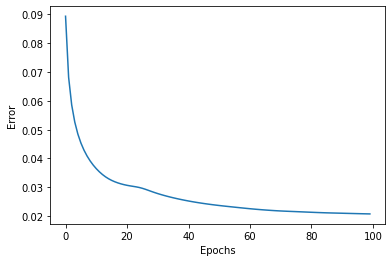

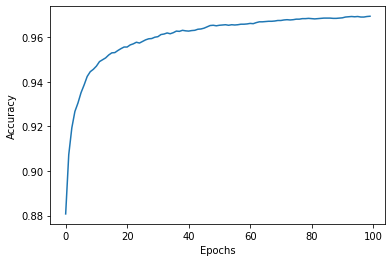

In [28]:
import matplotlib.pyplot as plt
errors, accuracies = calc_errors(input_pts, output_pts, (784, 100, 100, 10), learning_rate=.1, batch_size=100, num_epochs=100)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.plot(errors)
plt.show()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(accuracies)
plt.show()

Epoch 1 / 5:
Validation Error: 0.07792943916802138
Accuracy: 0.8808333333333334
Epoch 2 / 5:
Validation Error: 0.05694628964444785
Accuracy: 0.9170238095238096
Epoch 3 / 5:
Validation Error: 0.048486070521965206
Accuracy: 0.9304761904761905
Epoch 4 / 5:
Validation Error: 0.04320256356931302
Accuracy: 0.9376190476190476
Epoch 5 / 5:
Validation Error: 0.03990796553031403
Accuracy: 0.9434523809523809


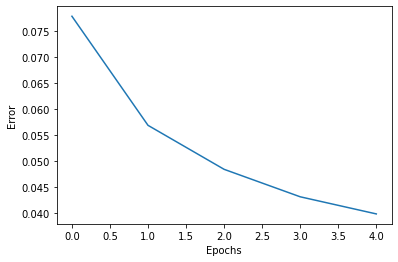

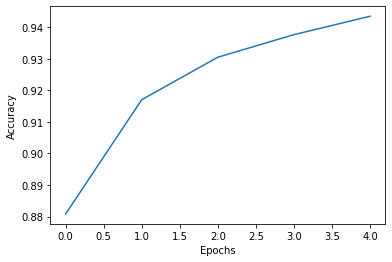

Epoch 1 / 5:
Validation Error: 0.07591403193153538
Accuracy: 0.8822619047619048
Epoch 2 / 5:
Validation Error: 0.05745929918502846
Accuracy: 0.9139285714285714
Epoch 3 / 5:
Validation Error: 0.046022974929305946
Accuracy: 0.9328571428571428
Epoch 4 / 5:
Validation Error: 0.03942318589774901
Accuracy: 0.9411904761904762
Epoch 5 / 5:
Validation Error: 0.03597716365592461
Accuracy: 0.9473809523809524


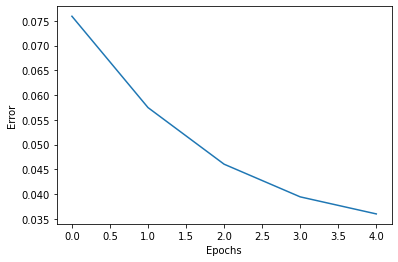

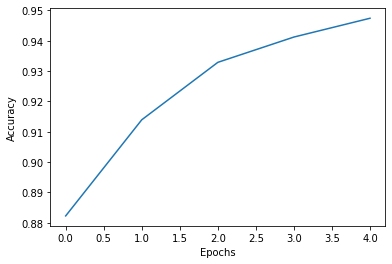

Epoch 1 / 5:
Validation Error: 0.20319799665779364
Accuracy: 0.631547619047619
Epoch 2 / 5:
Validation Error: 0.06594849763778973
Accuracy: 0.8966666666666666
Epoch 3 / 5:
Validation Error: 0.049105459697175884
Accuracy: 0.9230952380952381
Epoch 4 / 5:
Validation Error: 0.04858317674631474
Accuracy: 0.9252380952380952
Epoch 5 / 5:
Validation Error: 0.051174633749207034
Accuracy: 0.9225


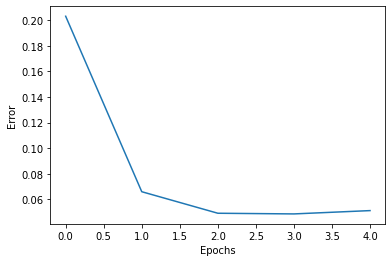

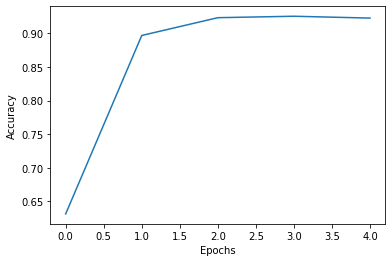

Epoch 1 / 5:
Validation Error: 0.3939051700625605
Accuracy: 0.08892857142857143
Epoch 2 / 5:
Validation Error: 0.3998911326960847
Accuracy: 0.10154761904761905
Epoch 3 / 5:
Validation Error: 0.3986057331598267
Accuracy: 0.1
Epoch 4 / 5:
Validation Error: 0.39973960856852464
Accuracy: 0.09535714285714286
Epoch 5 / 5:
Validation Error: 0.39979037074932716
Accuracy: 0.09547619047619048


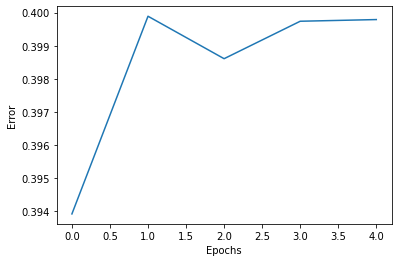

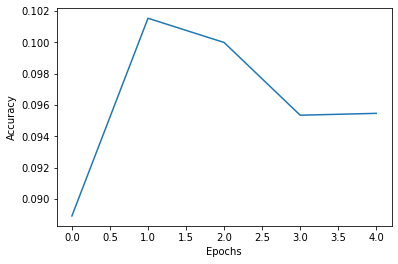

Epoch 1 / 5:


KeyboardInterrupt: 

In [34]:
for learning_rate in [0.2, 0.3, 0.4, 0.5, 1]:
    errors, accuracies = calc_errors(input_pts, output_pts, (784, 100, 100, 10), learning_rate=learning_rate, batch_size=100, num_epochs=5)
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.plot(errors)
    plt.show()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(accuracies)
    plt.show()

In [38]:
for rc in [1e-1]:
    errors, accuracies = calc_errors(input_pts, output_pts, (784, 100, 100, 10),
                                     learning_rate=0.2, batch_size=100, num_epochs=30,
                                     regularization_constant=rc)
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.plot(errors)
    plt.show()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(accuracies)
    plt.show()

Epoch 1 / 30:
Validation Error: 0.08036905402674088
Accuracy: 0.8870238095238095
Epoch 2 / 30:
Validation Error: 0.0675373657334563
Accuracy: 0.9036904761904762
Epoch 3 / 30:
Validation Error: 0.061154458084858754
Accuracy: 0.9134523809523809
Epoch 4 / 30:
Validation Error: 0.05760405487726344
Accuracy: 0.9202380952380952
Epoch 5 / 30:
Validation Error: 0.05535232913122954
Accuracy: 0.9234523809523809
Epoch 6 / 30:


KeyboardInterrupt: 

Epoch 1 / 150:
Validation Error: 0.0819979353053689
Accuracy: 0.8794047619047619
Epoch 2 / 150:
Validation Error: 0.060350235655727995
Accuracy: 0.91
Epoch 3 / 150:
Validation Error: 0.05085553002593094
Accuracy: 0.9223809523809524
Epoch 4 / 150:
Validation Error: 0.0453618565548686
Accuracy: 0.9332142857142857
Epoch 5 / 150:
Validation Error: 0.04225013540244521
Accuracy: 0.9371428571428572
Epoch 6 / 150:
Validation Error: 0.04050515643489532
Accuracy: 0.9385714285714286
Epoch 7 / 150:
Validation Error: 0.03928973343125264
Accuracy: 0.9417857142857143
Epoch 8 / 150:
Validation Error: 0.03842752476102173
Accuracy: 0.9422619047619047
Epoch 9 / 150:
Validation Error: 0.037792643559817686
Accuracy: 0.9434523809523809
Epoch 10 / 150:
Validation Error: 0.03697434999497208
Accuracy: 0.9454761904761905
Epoch 11 / 150:
Validation Error: 0.03571138946992175
Accuracy: 0.9471428571428572
Epoch 12 / 150:
Validation Error: 0.034288064381769665
Accuracy: 0.949047619047619
Epoch 13 / 150:
Validation 

Validation Error: 0.020914022878109232
Accuracy: 0.9702380952380952
Epoch 102 / 150:
Validation Error: 0.020915961809177368
Accuracy: 0.9702380952380952
Epoch 103 / 150:
Validation Error: 0.020929907505427416
Accuracy: 0.9703571428571428
Epoch 104 / 150:
Validation Error: 0.020957472034192945
Accuracy: 0.9705952380952381
Epoch 105 / 150:
Validation Error: 0.021009617305186853
Accuracy: 0.9707142857142858
Epoch 106 / 150:
Validation Error: 0.02109524474689689
Accuracy: 0.9703571428571428
Epoch 107 / 150:
Validation Error: 0.0212243470126829
Accuracy: 0.9703571428571428
Epoch 108 / 150:
Validation Error: 0.02137205554248809
Accuracy: 0.9703571428571428
Epoch 109 / 150:
Validation Error: 0.021405082182154384
Accuracy: 0.9704761904761905
Epoch 110 / 150:
Validation Error: 0.021241016202371597
Accuracy: 0.9707142857142858
Epoch 111 / 150:
Validation Error: 0.0211035240951205
Accuracy: 0.9703571428571428
Epoch 112 / 150:
Validation Error: 0.02103800997973246
Accuracy: 0.9704761904761905
Epoc

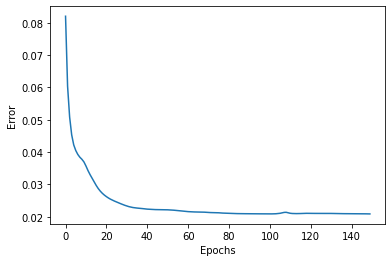

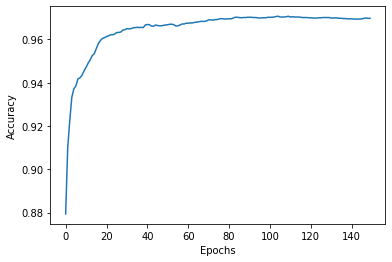

In [41]:
errors, accuracies = calc_errors(input_pts, output_pts, (784, 100, 100, 10), learning_rate=.2, batch_size=100, num_epochs=150)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.plot(errors)
plt.show()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(accuracies)
plt.show()

In [46]:
final_model = NeuralNetwork((784, 100, 100, 10), learning_rate=0.2)
final_model.sgd(input_pts, output_pts, batch_size=100, num_epochs=100)

Epoch 1 / 100
Epoch 2 / 100
Epoch 3 / 100
Epoch 4 / 100
Epoch 5 / 100
Epoch 6 / 100
Epoch 7 / 100
Epoch 8 / 100
Epoch 9 / 100
Epoch 10 / 100
Epoch 11 / 100
Epoch 12 / 100
Epoch 13 / 100
Epoch 14 / 100
Epoch 15 / 100
Epoch 16 / 100
Epoch 17 / 100
Epoch 18 / 100
Epoch 19 / 100
Epoch 20 / 100
Epoch 21 / 100
Epoch 22 / 100
Epoch 23 / 100
Epoch 24 / 100
Epoch 25 / 100
Epoch 26 / 100
Epoch 27 / 100
Epoch 28 / 100
Epoch 29 / 100
Epoch 30 / 100
Epoch 31 / 100
Epoch 32 / 100
Epoch 33 / 100
Epoch 34 / 100
Epoch 35 / 100
Epoch 36 / 100
Epoch 37 / 100
Epoch 38 / 100
Epoch 39 / 100
Epoch 40 / 100
Epoch 41 / 100
Epoch 42 / 100
Epoch 43 / 100
Epoch 44 / 100
Epoch 45 / 100
Epoch 46 / 100
Epoch 47 / 100
Epoch 48 / 100
Epoch 49 / 100
Epoch 50 / 100
Epoch 51 / 100
Epoch 52 / 100
Epoch 53 / 100
Epoch 54 / 100
Epoch 55 / 100
Epoch 56 / 100
Epoch 57 / 100
Epoch 58 / 100
Epoch 59 / 100
Epoch 60 / 100
Epoch 61 / 100
Epoch 62 / 100
Epoch 63 / 100
Epoch 64 / 100
Epoch 65 / 100
Epoch 66 / 100
Epoch 67 / 100
Epoc

In [47]:
test_data = pd.read_csv("test.csv")
test_data

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
num_test_pts = len(test_data)
input_test_pts = test_data.to_numpy() * 2 / 255 - 1

In [56]:
generated_output_layers = final_model.compute_output_layers(input_test_pts)
generated_answers = [np.argmax(layer) for layer in generated_output_layers]

[[-0.99979004 -0.99999996  0.99998581 ... -0.99993664 -0.99999862
  -0.99999653]
 [ 0.99992538 -0.99996837 -0.99973044 ... -0.99994514 -0.99999758
  -0.99998379]
 [-0.99999902 -0.99998405 -0.99962107 ... -0.99978621 -0.99998166
   0.97221848]
 ...
 [-0.9999974  -0.99993472 -0.99990158 ... -0.99998912 -0.99997871
  -0.9998309 ]
 [-0.99986698 -0.99999972 -0.99999983 ... -0.99979453 -0.99999651
   0.92005765]
 [-0.99996818 -1.          0.99999354 ... -0.99999927 -0.99999835
  -0.99998828]]
[2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1, 5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 5, 4, 1, 7, 0, 0, 0, 1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 8, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4, 0, 9, 2, 0, 7, 3, 0, 5, 0, 8, 0, 0, 4, 7, 1, 7, 1, 1, 3, 3, 3, 7, 2, 8, 6, 3, 8, 7, 8, 4, 3, 5, 6, 0, 0, 0, 3, 1, 3, 6, 4, 3, 4, 5, 5, 8, 7, 7, 2, 8, 4, 3, 5, 6, 5, 3, 7, 5, 7, 8, 3, 0, 4, 5, 1, 2, 7, 6, 3, 

In [59]:
output_dataframe = pd.DataFrame({"ImageID" : np.arange(1, num_test_pts + 1),
                                 "Label" : generated_answers})

In [62]:
output_dataframe.to_csv("answers.csv", index=False)